In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader

In [2]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms

from utils.eval_funcs import *
from utils.dataset_CIFAR100LT import *
from utils.network_arch_resnet import *
from utils.trainval import *
from utils.plot_funcs import *
import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
2.0.1


In [3]:
classes=[]
for i in range(100):
    classes.append(i)

In [4]:
'''
cnn_acc=[47.00,33.00,18.00,4.00,14.00,15.00,25.00,26.00,41.00,53.00,13.00,11.00,29.00,13.00,19.00,18.00,
         31.00,45.00,14.00,20.00,54.00,41.00,25.00,50.00,53.00,15.00,22.00,9.00,41.00,26.00,22.00,34.00,
         16.00,19.00,20.00,14.00,17.00,16.00,12.00,25.00,27.00,48.00,20.00,24.00,6.00,9.00,10.00,38.00,
         46.00,37.00,9.00,12.00,39.00,65.00,32.00,4.00,40.00,29.00,24.00,11.00,48.00,48.00,43.00,18.00,
         7.00,9.00,9.00,12.00,62.00,50.00,22.00,43.00,3.00,32.00,23.00,42.00,33.00,11.00,16.00,22.00,
         9.00,27.00,52.00,29.00,14.00,29.00,39.00,33.00,17.00,21.00,14.00,34.00,14.00,17.00,55.00,23.00,
         25.00,28.00,22.00,12.00]
'''

'\ncnn_acc=[47.00,33.00,18.00,4.00,14.00,15.00,25.00,26.00,41.00,53.00,13.00,11.00,29.00,13.00,19.00,18.00,\n         31.00,45.00,14.00,20.00,54.00,41.00,25.00,50.00,53.00,15.00,22.00,9.00,41.00,26.00,22.00,34.00,\n         16.00,19.00,20.00,14.00,17.00,16.00,12.00,25.00,27.00,48.00,20.00,24.00,6.00,9.00,10.00,38.00,\n         46.00,37.00,9.00,12.00,39.00,65.00,32.00,4.00,40.00,29.00,24.00,11.00,48.00,48.00,43.00,18.00,\n         7.00,9.00,9.00,12.00,62.00,50.00,22.00,43.00,3.00,32.00,23.00,42.00,33.00,11.00,16.00,22.00,\n         9.00,27.00,52.00,29.00,14.00,29.00,39.00,33.00,17.00,21.00,14.00,34.00,14.00,17.00,55.00,23.00,\n         25.00,28.00,22.00,12.00]\n'

In [5]:
cnn_acc=[]

In [6]:
resnet18_acc=[]

In [7]:
resnet50_acc=[]

In [8]:
resnet18_moreEpoches_acc=[]

In [9]:
resnet18_none_acc=[]

In [10]:
import re
with open("cnn.txt", "r") as file:
    input_data = file.read()
# Split the input string by "Accuracy of class"
data = input_data.split("Accuracy of class")

# Create a dictionary to store the accuracies
accuracies = {}

# Loop through the data and extract the class and accuracy
for entry in data[1:]:
    match = re.search(r"(\d+):\s(\d+\.\d+)%", entry)
    class_num = match.group(1)
    accuracy = match.group(2)
    accuracies[class_num] = float(accuracy)

# Print the accuracies
for class_num, accuracy in accuracies.items():
    #print(f"Class {class_num}: {accuracy}%")
    cnn_acc.append(accuracy)
    
    
print(cnn_acc)

[47.0, 33.0, 18.0, 4.0, 14.0, 15.0, 25.0, 26.0, 41.0, 53.0, 13.0, 11.0, 29.0, 13.0, 19.0, 18.0, 31.0, 45.0, 14.0, 20.0, 54.0, 41.0, 25.0, 50.0, 53.0, 15.0, 22.0, 9.0, 41.0, 26.0, 22.0, 34.0, 16.0, 19.0, 20.0, 14.0, 17.0, 16.0, 12.0, 25.0, 27.0, 48.0, 20.0, 24.0, 6.0, 9.0, 10.0, 38.0, 46.0, 37.0, 9.0, 12.0, 39.0, 65.0, 32.0, 4.0, 40.0, 29.0, 24.0, 11.0, 48.0, 48.0, 43.0, 18.0, 7.0, 9.0, 9.0, 12.0, 62.0, 50.0, 22.0, 43.0, 3.0, 32.0, 23.0, 42.0, 33.0, 11.0, 16.0, 22.0, 9.0, 27.0, 52.0, 29.0, 14.0, 29.0, 39.0, 33.0, 17.0, 21.0, 14.0, 34.0, 14.0, 17.0, 55.0, 23.0, 25.0, 28.0, 22.0, 12.0]


In [11]:
import re
with open("resnet18_none.txt", "r") as file:
    input_data = file.read()
# Split the input string by "Accuracy of class"
data = input_data.split("Accuracy of class")

# Create a dictionary to store the accuracies
accuracies = {}

# Loop through the data and extract the class and accuracy
for entry in data[1:]:
    match = re.search(r"(\d+):\s(\d+\.\d+)%", entry)
    class_num = match.group(1)
    accuracy = match.group(2)
    accuracies[class_num] = float(accuracy)

# Print the accuracies
for class_num, accuracy in accuracies.items():
    #print(f"Class {class_num}: {accuracy}%")
    resnet18_none_acc.append(accuracy)
    
    
print(resnet18_none_acc)

[81.0, 73.0, 41.0, 24.0, 36.0, 60.0, 59.0, 58.0, 69.0, 68.0, 38.0, 31.0, 65.0, 35.0, 52.0, 48.0, 59.0, 70.0, 52.0, 48.0, 79.0, 73.0, 50.0, 82.0, 74.0, 44.0, 50.0, 38.0, 71.0, 51.0, 56.0, 54.0, 42.0, 51.0, 56.0, 27.0, 57.0, 44.0, 40.0, 86.0, 54.0, 68.0, 52.0, 67.0, 28.0, 34.0, 32.0, 53.0, 84.0, 73.0, 34.0, 58.0, 63.0, 84.0, 59.0, 26.0, 79.0, 61.0, 58.0, 48.0, 80.0, 65.0, 70.0, 53.0, 33.0, 35.0, 36.0, 47.0, 85.0, 81.0, 62.0, 67.0, 18.0, 44.0, 39.0, 85.0, 90.0, 47.0, 53.0, 62.0, 29.0, 54.0, 79.0, 50.0, 40.0, 68.0, 65.0, 64.0, 52.0, 55.0, 59.0, 66.0, 47.0, 30.0, 87.0, 61.0, 49.0, 60.0, 27.0, 72.0]


In [12]:
import re
with open("resnet18.txt", "r") as file:
    input_data = file.read()
# Split the input string by "Accuracy of class"
data = input_data.split("Accuracy of class")

# Create a dictionary to store the accuracies
accuracies = {}

# Loop through the data and extract the class and accuracy
for entry in data[1:]:
    match = re.search(r"(\d+):\s(\d+\.\d+)%", entry)
    class_num = match.group(1)
    accuracy = match.group(2)
    accuracies[class_num] = float(accuracy)

# Print the accuracies
for class_num, accuracy in accuracies.items():
    #print(f"Class {class_num}: {accuracy}%")
    resnet18_acc.append(accuracy)
    
    
print(resnet18_acc)

[90.0, 81.0, 54.0, 46.0, 48.0, 72.0, 68.0, 70.0, 76.0, 74.0, 42.0, 35.0, 67.0, 50.0, 58.0, 54.0, 64.0, 76.0, 48.0, 42.0, 84.0, 72.0, 52.0, 79.0, 77.0, 36.0, 49.0, 31.0, 67.0, 48.0, 52.0, 44.0, 35.0, 48.0, 49.0, 24.0, 47.0, 40.0, 36.0, 75.0, 41.0, 70.0, 47.0, 60.0, 16.0, 29.0, 36.0, 60.0, 75.0, 64.0, 25.0, 43.0, 59.0, 75.0, 54.0, 15.0, 68.0, 48.0, 54.0, 43.0, 65.0, 53.0, 55.0, 38.0, 21.0, 23.0, 31.0, 31.0, 71.0, 68.0, 30.0, 66.0, 14.0, 38.0, 16.0, 61.0, 73.0, 29.0, 40.0, 49.0, 20.0, 45.0, 65.0, 35.0, 31.0, 65.0, 52.0, 63.0, 40.0, 42.0, 46.0, 59.0, 29.0, 23.0, 81.0, 48.0, 31.0, 40.0, 21.0, 57.0]


In [13]:
import re
with open("resnet50.txt", "r") as file:
    input_data = file.read()
# Split the input string by "Accuracy of class"
data = input_data.split("Accuracy of class")

# Create a dictionary to store the accuracies
accuracies = {}

# Loop through the data and extract the class and accuracy
for entry in data[1:]:
    match = re.search(r"(\d+):\s(\d+\.\d+)%", entry)
    class_num = match.group(1)
    accuracy = match.group(2)
    accuracies[class_num] = float(accuracy)

# Print the accuracies
for class_num, accuracy in accuracies.items():
    #print(f"Class {class_num}: {accuracy}%")
    resnet50_acc.append(accuracy)
    
    
print(resnet50_acc)

[92.0, 87.0, 62.0, 52.0, 51.0, 73.0, 70.0, 68.0, 84.0, 77.0, 57.0, 40.0, 73.0, 63.0, 65.0, 51.0, 64.0, 77.0, 55.0, 45.0, 87.0, 78.0, 60.0, 81.0, 75.0, 41.0, 48.0, 45.0, 76.0, 54.0, 57.0, 50.0, 52.0, 49.0, 46.0, 21.0, 60.0, 38.0, 37.0, 76.0, 48.0, 70.0, 52.0, 61.0, 22.0, 30.0, 21.0, 58.0, 82.0, 62.0, 25.0, 48.0, 56.0, 80.0, 57.0, 16.0, 65.0, 50.0, 63.0, 55.0, 77.0, 50.0, 53.0, 41.0, 24.0, 30.0, 39.0, 23.0, 69.0, 67.0, 48.0, 62.0, 15.0, 42.0, 30.0, 66.0, 73.0, 31.0, 44.0, 46.0, 22.0, 44.0, 68.0, 41.0, 32.0, 52.0, 56.0, 59.0, 47.0, 46.0, 37.0, 58.0, 32.0, 23.0, 82.0, 51.0, 41.0, 46.0, 33.0, 57.0]


In [14]:
import re
with open("resnet18_moreEpoches.txt", "r") as file:
    input_data = file.read()
# Split the input string by "Accuracy of class"
data = input_data.split("Accuracy of class")

# Create a dictionary to store the accuracies
accuracies = {}

# Loop through the data and extract the class and accuracy
for entry in data[1:]:
    match = re.search(r"(\d+):\s(\d+\.\d+)%", entry)
    class_num = match.group(1)
    accuracy = match.group(2)
    accuracies[class_num] = float(accuracy)

# Print the accuracies
for class_num, accuracy in accuracies.items():
    #print(f"Class {class_num}: {accuracy}%")
    resnet18_moreEpoches_acc.append(accuracy)
    
    
print(resnet18_moreEpoches_acc)

[86.0, 80.0, 55.0, 52.0, 54.0, 68.0, 64.0, 70.0, 74.0, 68.0, 39.0, 36.0, 64.0, 54.0, 62.0, 50.0, 60.0, 73.0, 56.0, 48.0, 82.0, 75.0, 57.0, 79.0, 73.0, 41.0, 45.0, 32.0, 71.0, 45.0, 55.0, 56.0, 42.0, 45.0, 44.0, 26.0, 45.0, 46.0, 40.0, 80.0, 45.0, 67.0, 48.0, 63.0, 26.0, 28.0, 27.0, 47.0, 76.0, 61.0, 18.0, 44.0, 62.0, 86.0, 61.0, 20.0, 68.0, 51.0, 57.0, 41.0, 69.0, 56.0, 48.0, 41.0, 21.0, 36.0, 31.0, 38.0, 72.0, 67.0, 50.0, 55.0, 18.0, 38.0, 27.0, 63.0, 73.0, 36.0, 32.0, 40.0, 24.0, 43.0, 66.0, 40.0, 32.0, 54.0, 48.0, 63.0, 45.0, 53.0, 49.0, 54.0, 42.0, 15.0, 79.0, 51.0, 45.0, 40.0, 29.0, 58.0]


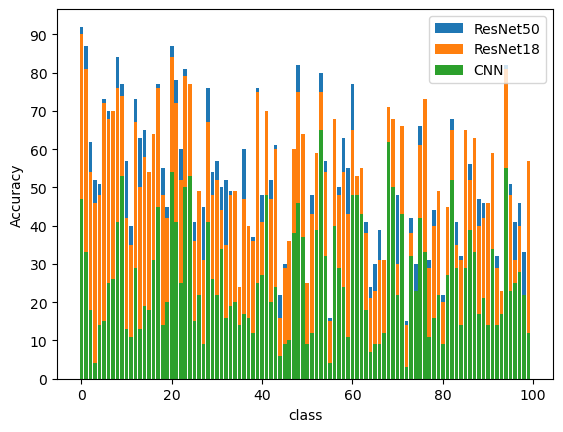

In [15]:
plt.xlabel('class')
plt.ylabel('Accuracy')
#plt.title("The change of accuracy under different classess")
#plt.plot(class_number, class_acc, linewidth=2,  marker='.')

plt.bar(classes, resnet50_acc,label="ResNet50")
plt.bar(classes, resnet18_acc,label="ResNet18")
plt.bar(classes, cnn_acc,label="CNN")

plt.yticks([0, 10, 20, 30, 40, 50,60,70,80,90]) 
#plt.gca().invert_yaxis() 
plt.legend()
plt.show()

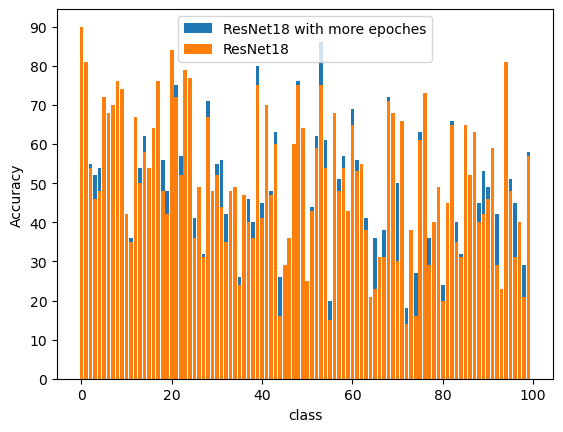

In [16]:
plt.xlabel('class')
plt.ylabel('Accuracy')
#plt.title("The change of accuracy under different classess")
#plt.plot(class_number, class_acc, linewidth=2,  marker='.')
plt.bar(classes, resnet18_moreEpoches_acc,label="ResNet18 with more epoches")
plt.bar(classes, resnet18_acc,label="ResNet18")


plt.yticks([0, 10, 20, 30, 40, 50,60,70,80,90]) 
#plt.gca().invert_yaxis() 
plt.legend()
plt.show()

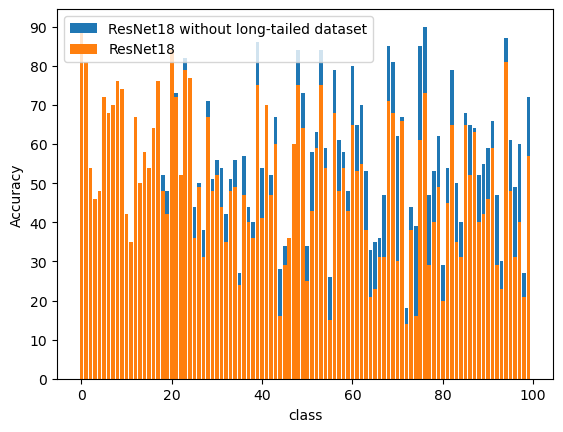

In [17]:
plt.xlabel('class')
plt.ylabel('Accuracy')
#plt.title("The change of accuracy under different classess")
#plt.plot(class_number, class_acc, linewidth=2,  marker='.')
plt.bar(classes, resnet18_none_acc,label="ResNet18 without long-tailed dataset")
plt.bar(classes, resnet18_acc,label="ResNet18")


plt.yticks([0, 10, 20, 30, 40, 50,60,70,80,90]) 
#plt.gca().invert_yaxis() 
plt.legend()
plt.show()